# MULTIVARIATE ANALYSIS CODE

In [1]:
# Libraries used for multivariate analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import pyplot
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib.ticker import PercentFormatter
import zipfile
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.stattools import durbin_watson
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
from scipy.stats import gmean
from geopandas import gpd
import rasterio
from rasterio.transform import Affine
from rasterio.enums import Resampling
import rioxarray
from functools import partial
from rasterio.enums import MergeAlg
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from sklearn.model_selection import train_test_split
from matplotlib.gridspec import GridSpec as gspec

# Fonr used for most figures
font = {'family':'Bahnschrift', 'fontsize' : 16}
# Ignore warnings while running this code (It is recommended to uncomment this line)
warnings.filterwarnings('ignore')

%matplotlib inline

## Radon concentrations analysis
We import the radon concentrations measured. (RAW DATA)

In [2]:
# Import dataframe
DF = pd.read_excel('Dataset for fitting/Raw_Results_LR115.xlsx')

#Drop NA data
DF_data = DF[(DF['Concentracion_Bq_m3'].notna())] 

# Calculate Percentage error
DF_data['Error_perc'] = DF_data.apply(lambda df: 100*np.abs(df['Concentracion_Bq_m3'] - df['Contramuestra'])/df['Resultado'], axis = 1) #Add error column
# Get ID of sample as numeric
DF_data.ID_muestra = DF_data.ID_muestra.apply(lambda df : int(str(df)[:2]))

# Set house ID as index
DF_data = DF_data.set_index('ID_casa')

DF_data

,ID_muestra,dias_muestreo,Concentracion_Bq_m3,Contramuestra,Resultado,Error_perc
ID_casa,,,,,,
1,20,35,175.00,NaN,175.000,NaN
10,3,35,46.86,NaN,46.860,NaN
16,7,35,81.80,NaN,81.800,NaN
17,16,36,173.91,180.26,177.085,3.585849
19,19,35,107.13,130.00,118.565,19.288998
22,4,35,61.80,NaN,61.800,NaN
24,14,36,40.75,50.00,45.375,20.385675
26,15,36,182.30,170.00,176.150,6.982685
28,5,35,15.40,NaN,15.400,NaN


### Import data of all the variables

In [3]:
# Import dataset with preprocessed data (Radon concentrations and Predictors (Gathered from multiple sources (Geologic data, meterologic data, Survey)))
DF_RC = pd.read_csv('Dataset for fitting/Processed_DataFrame.csv')

### Basic statistics

<Axes: >

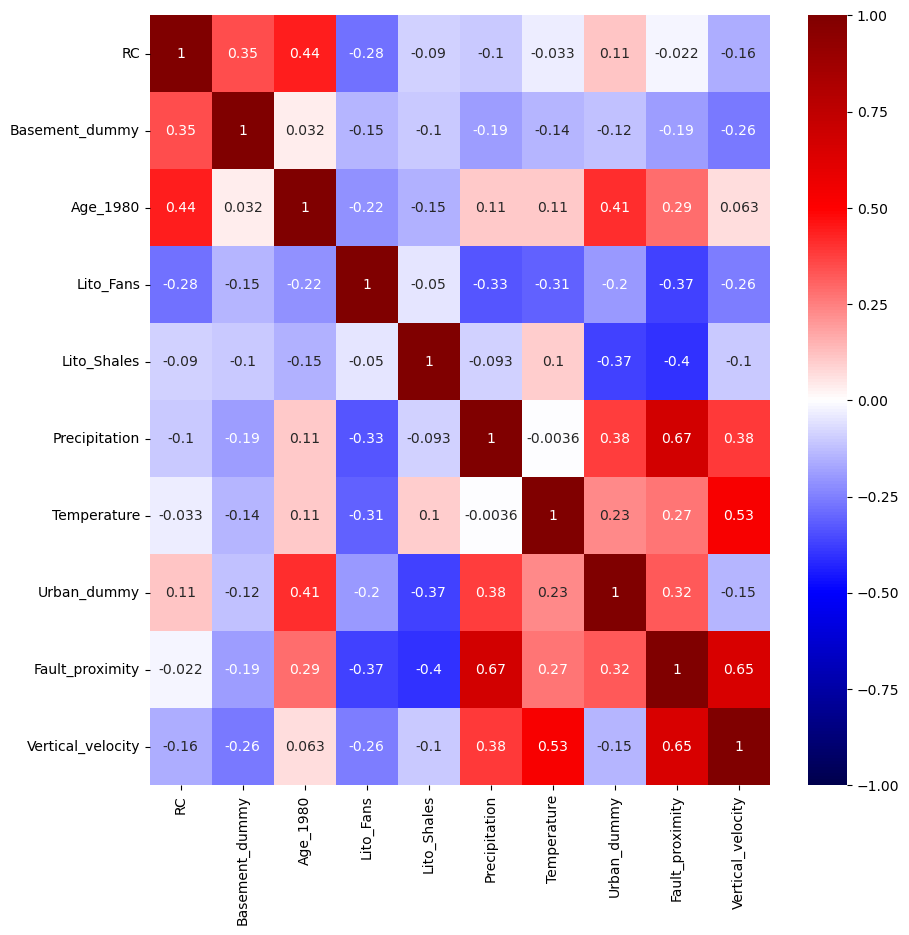

In [4]:
# Names of selected variables for Statistical analysis 
Variables = [
             'Basement dummy',
             'House age (1980 dummy)',
             'Lithology Q-ca dummy',
             'Lithology k1k6-Stm dummy',
             'Precipitation [mm]',
             'Temperature [°C]',
             'Urban dummy',
             'Fault proximity',
             'Vertical velocity'
            ]

# Subsetting only the variables (Dependent and Independent)
DF_RC = DF_RC.iloc[:,1:]

# Create correlation matrix
plt.figure(figsize = (10,10))
sns.heatmap(DF_RC.corr(), vmax=1, vmin=-1, center=0, cmap='seismic', annot = True)

### Independent variable caracterization

The following lines of code create a summary plot for all of the independent variables for this specific dataset.

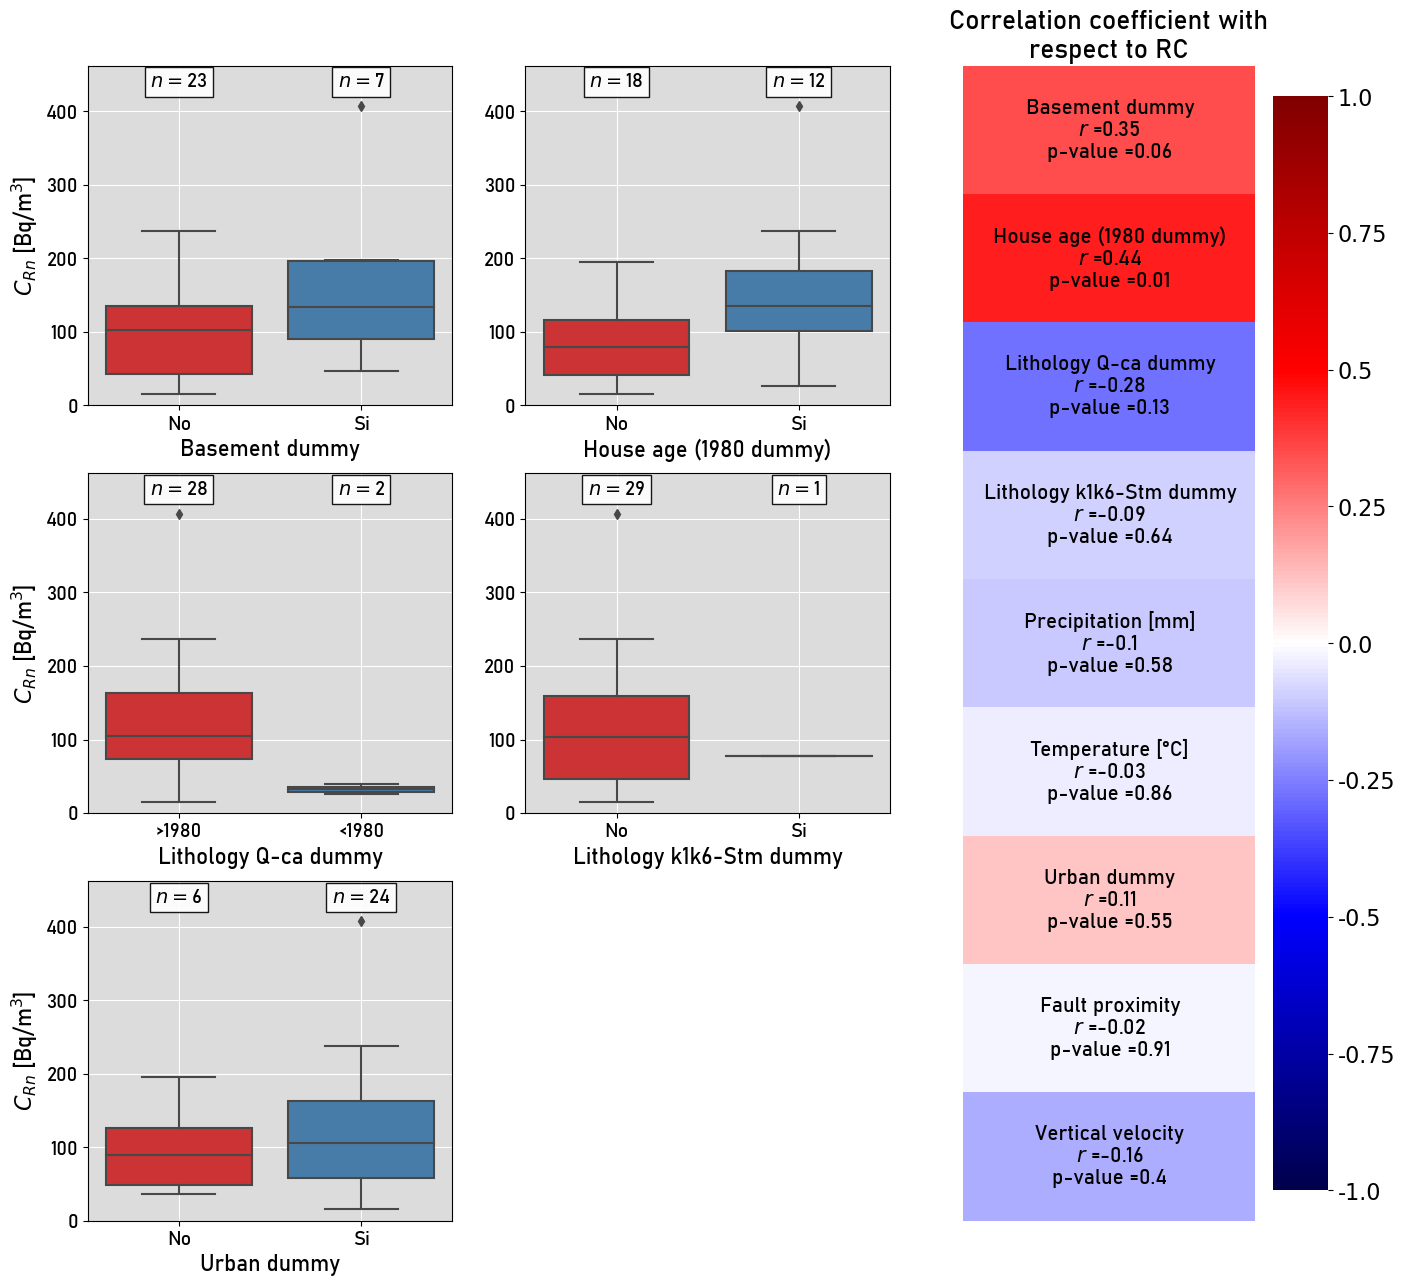

In [5]:
# r-pearson for variables with RC
r_Pvals = []
for i in range(len(DF_RC.columns)-1):
    r_Pvals.append(stats.pearsonr(np.array(DF_RC.RC), np.array(DF_RC.iloc[:,i+1])))
    

fig = plt.figure(figsize = (16,15))
k = 0

for i in [1, 2, 3, 4, 7]:
    
    if k<2:
        plt.subplot2grid((3,3), (0,k))
    elif k < 4:
        plt.subplot2grid((3,3), (1,k-2))
    else:
        plt.subplot2grid((3,3), (2,k-4))
    k+=1
    
    plt.ylim((0,462))
    ax=plt.gca()
    ax.set_facecolor('gainsboro')
    ax.set_axisbelow(True)
    
    ax2 = sns.boxplot(y = DF_RC.RC, x = DF_RC.iloc[:,i], palette = sns.color_palette("Set1"), zorder = 2)
    
    for j in range(len(DF_RC.iloc[:,i].unique())):
        if i == 3:
            plt.text(j,440,'$n = $'+str(sum(DF_RC.iloc[:,i] == j)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['>1980', '<1980'], family = 'bahnschrift', fontsize=14)
        else:
            plt.text(j,440,'$n = $'+str(sum(DF_RC.iloc[:,i] == j)), ha = 'center', va = 'center', bbox = dict(facecolor='w', alpha=0.9), fontdict = dict(family = 'bahnschrift', fontsize = 14))
            ax2.set_xticklabels(['No', 'Si'], family = 'bahnschrift', fontsize=14)
    ax2.set_yticklabels([0,100,200,300,400], family = 'bahnschrift',fontsize=14)
    if (k != 1) and (k!=3) and (k!=5):
        ax2.set_ylabel('')
    else:
        ax2.set_ylabel('$C_{Rn}$ [Bq/m$^3$]', fontsize=16, family = 'bahnschrift')
    ax2.set_xlabel(Variables[i-1], fontsize=16, family = 'bahnschrift')
    ax2.grid(color = 'w', zorder = -3)
    
ax7 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)

Val = []
for i in range(len(Variables)):
    Val.append(Variables[i] + '\n$r$ =' +str(round(r_Pvals[i][0], 2)) + '\np-value =' +str(round(r_Pvals[i][1], 2)))

ax = sns.heatmap(pd.DataFrame(DF_RC.corr()['RC'].iloc[1:]), center = 0, vmin = -1, vmax = 1, cmap = 'seismic')
ax.set_yticklabels(Val, rotation = 0, x = 0.52, ha = 'center', family='bahnschrift', fontsize = 15)
ax.figure.axes[-1].set_yticklabels(np.arange(-1, 1.1, 0.25), size=16)
ax.tick_params(length = 0)
ax.set_xticklabels([''], rotation = 0)
ax.set_title('Correlation coefficient with\nrespect to RC', family='bahnschrift', fontsize = 19)

fig.savefig('Figures/Caracterization.png', dpi = 300, bbox_inches = 'tight')

### Principal component Analysis

In order to understand the relationships between independent variables and between them and the dependendent variable, a Principal Component Analysis was performed and the BiPlot is plotted with the scores and the eigen vectors.

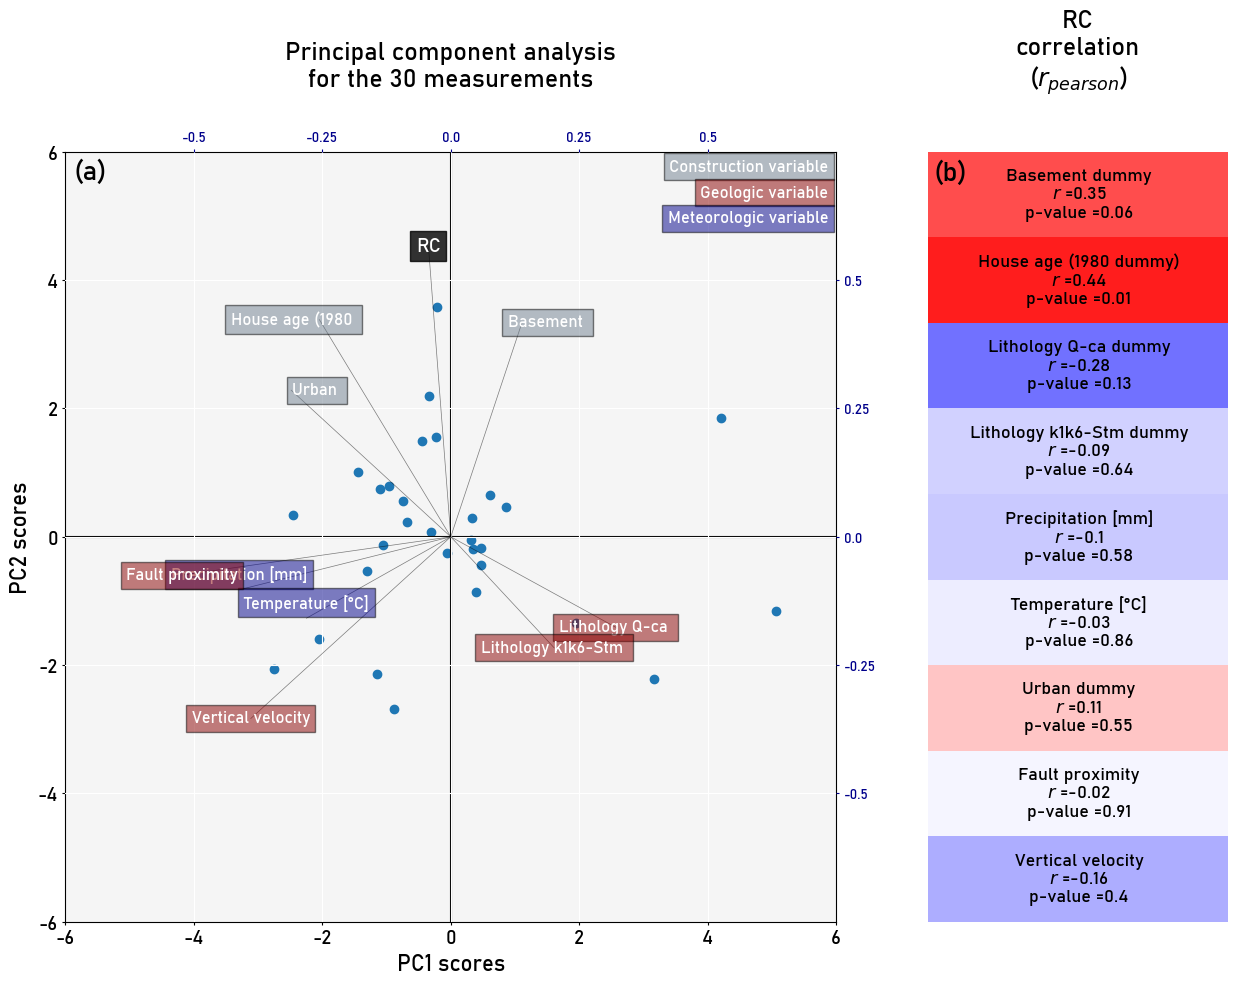

In [6]:
df_PCA = DF_RC

# Standarization
df_PCA = df_PCA.apply(lambda df : (df - np.mean(df))/np.std(df) )

Variables.insert(0,'RC')
df_PCA.columns = Variables

df_ = pd.DataFrame(df_PCA.corr().iloc[0,1:])

n_PCA = 5
pca = PCA(n_PCA)
A_postPCA = pca.fit_transform(df_PCA)
A_postPCA = pd.DataFrame(A_postPCA)

# Name the columns
cols = []
for i in range(len(A_postPCA.T)):
    cols.append('PC'+str(i+1))

A_postPCA.columns = cols

EigenVectors = pd.DataFrame(pca.components_.T)

fig = plt.figure(figsize = (15,10))

gs = gspec(10,15)

ax1=fig.add_subplot(gs[:,:10], label="1")
ax2=fig.add_subplot(gs[:,:10], label="2", frame_on=False)

ax1.scatter(A_postPCA.PC1, A_postPCA.PC2)

ax1.set_xlabel("PC1 scores", color="k", fontfamily = 'bahnschrift', fontsize = 16)
ax1.set_ylabel("PC2 scores", color="k", fontfamily  = 'bahnschrift', fontsize = 16)
ax1.tick_params(axis='x', colors="k", length = 2)
ax1.tick_params(axis='y', colors="k", length = 2)
ax2.set_xticks(np.arange(-6,7,2))
ax2.set_yticks(np.arange(-6,7,2))
ax1.set_yticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)
ax1.set_xticklabels(np.arange(-6,7,2), family = 'bahnschrift', size = 14)

plt.grid(True, color = 'w')

ax1.axhline(0,c='k')
ax1.axvline(0,c='k')

ax1.set_xlim(-6,6)
ax1.set_ylim(-6,6)


for i in range(len(EigenVectors)):
    ax2.plot([0,EigenVectors.iloc[i,0]],[0, EigenVectors.iloc[i,1]], c = 'k', lw = 0.5, alpha=0.5)
    if (i == 1)|(i == 7):
        plt.text(EigenVectors.iloc[i,0]+0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 2):
        plt.text(EigenVectors.iloc[i,0]-0.05, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='slategrey', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 3)|(i == 4)|(i == 9)|(i == 8):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 1):
        plt.text(EigenVectors.iloc[i,0]-.1, EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkred', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    elif (i == 6)|(i == 5):
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1]+0.03, df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='darkblue', alpha = 0.5), fontsize = 12, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
    else:
        plt.text(EigenVectors.iloc[i,0], EigenVectors.iloc[i,1], df_PCA.iloc[:,i].name.split('dummy')[0], bbox = dict(facecolor='k', alpha = 0.8), fontsize = 14, fontfamily = 'bahnschrift', ha = 'center',va = 'center', color='w')
        

    
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.set_xticks(np.arange(-0.5,.7,.25))
ax2.set_yticks(np.arange(-0.5,.7,.25))
ax2.set_yticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.set_xticklabels(np.arange(-0.5,.7,.25), family = 'bahnschrift', size = 10)
ax2.tick_params(axis='x', colors="darkblue",length = 2)
ax2.tick_params(axis='y', colors="darkblue",length = 2)

ax2.set_xlim(-.75,.75)
ax2.set_ylim(-.75,.75)

plt.text(-0.735,.736,'(a)', ha = 'left', va='top', fontsize = 20, fontfamily = 'bahnschrift')

plt.text(0.735,.736,'Construction variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='slategray', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.686,'Geologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkred', alpha = 0.5), fontfamily = 'bahnschrift')
plt.text(0.735,.636,'Meteorologic variable', ha = 'right', va='top', fontsize = 12, color = 'w', bbox = dict(facecolor='darkblue', alpha = 0.5), fontfamily = 'bahnschrift')


plt.title('Principal component analysis\nfor the 30 measurements', y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

ax1.set_facecolor('whitesmoke')

ax3 = fig.add_subplot(gs[:,11:], label='3')

df_ = df_PCA.corr(method = 'pearson').apply(lambda df : df[np.abs(df) >= 0.0])
df_ = df_.loc[df_.columns]
df_ = pd.DataFrame(df_.iloc[1:,0])
sns.heatmap(df_, cmap='seismic', vmin = -1,vmax = 1, alpha = 1, cbar = False, zorder = -2)

ax3.tick_params(axis='x', length = 0)
ax3.tick_params(axis='y', length = 0)

Val = []
for i in range(len(df_PCA.columns)-1):
    Val.append(list(df_PCA.columns)[i+1] + '\n$r$ =' +str(round(r_Pvals[i][0], 2)) + '\np-value =' +str(round(r_Pvals[i][1], 2)))
    
ax3.set_yticklabels(Val, rotation = 0, x = 0.52 , ha = 'center', family='bahnschrift', fontsize = 13, color = 'k', zorder = 5)

ax3.set_xticklabels([''], rotation = 0)

plt.text(0.02,0.1,'(b)', ha = 'left', va='top', fontsize = 20, fontfamily = 'bahnschrift')

plt.title('RC\ncorrelation\n($r_{pearson}$)',  y = 1.075, fontsize = 18, fontfamily = 'bahnschrift')

fig.savefig('Figures/PCA_RC.png', dpi  = 170, bbox_inches = 'tight')

Variables.remove('RC')

## Statistical regression models
In this section the log-linear regression is fitted and feature selection is performed.

In [7]:
# Split datataset in predictors (X) and predicted variable (y) 
X = DF_RC.iloc[:,1:]
y = DF_RC.iloc[:,0]

# Add a a constant to the predictors
X = sm.add_constant(X)

### Log-Linear regression
The following lines fit a linear regression to the dataset using Ordinary Least Squares Method

In [8]:
lin_reg = sm.OLS(np.log(y), X).fit(maxiter=1000)

RMSE = np.sqrt(np.sum((lin_reg.predict(X)-np.log(y))**2)/30)

print('RMSE:', RMSE)

lin_reg.summary()

RMSE: 0.5468621886828955


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RC   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     1.838
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.123
Time:                        20:56:51   Log-Likelihood:                -24.461
No. Observations:                  30   AIC:                             68.92
Df Residuals:                      20   BIC:                             82.93
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.5576     14.352     -0.318      0.754     -34.495      25.380
Basement_dummy        0.0994      0.341      0.291      0.774      -0.613       0.812
Age_1980              0.6932      0.307      2.255      0.035       0.052       1.334
Lito_Fans            -1.1148      0.598     -1.865      0.077      -2.362       0.132
Lito_Shales          -0.7174      1.089     -0.659      0.517      -2.988       1.554
Precipitation         0.0027      0.018      0.150      0.882      -0.034       0.040
Temperature           0.8159      1.029      0.793      0.437      -1.331       2.962
Urban_dummy          -0.9269      0.683     -1.356      0.190      -2.352       0.499
Fault_proximity     5.31e-05   8.08e-05      0.657      0.519      -0.000       0.000
Vertical_velocity    -1.2007      0.704     -1.706      0.104      -2.669       0.267
==============================================================================
Omnibus:                        4.879   Durbin-Watson:                   2.499
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                3.359
Skew:                          -0.543   Prob(JB):                        0.186
Kurtosis:                       4.228   Cond. No.                     8.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Coefficient visualization 

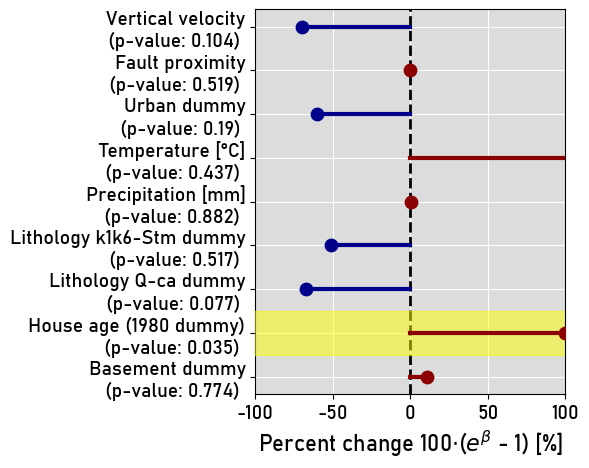

In [9]:
def coef_vis(lin_reg, Variables, fig_name):
    fig = plt.figure(figsize = (4,5))

    plt.grid(True, which = 'both',  zorder = -3, c = 'w')

    for i in range(len(lin_reg.params.iloc[:-1])):
        if lin_reg.params.iloc[i+1] > 0:
            plt.scatter(np.exp(lin_reg.params.iloc[i+1]) - 1, Variables[i], s = 80, c = 'darkred', zorder = 4)
            plt.plot([0,np.exp(lin_reg.params.iloc[i+1]) - 1], [Variables[i], Variables[i]], c = 'darkred', linewidth = 3, zorder = 4)
        else:
            plt.scatter(np.exp(lin_reg.params.iloc[i+1]) - 1, Variables[i], s = 80, c = 'darkblue', zorder = 4)
            plt.plot([0,(np.exp(lin_reg.params.iloc[i+1]) - 1)], [Variables[i], Variables[i]], c = 'darkblue', linewidth = 3, zorder = 4)

    Val = []
    sig_ind = []
    for i in range(len(Variables)):
        Val.append(Variables[i] + '\n(p-value: '+str(round(lin_reg.pvalues.iloc[i+1],3))+') ')
        if lin_reg.pvalues.iloc[i+1] < 0.05:
            sig_ind.append(i)

    ax = plt.gca()

    ax.set_xlabel('Percent change 100$\cdot$($e^{\u03B2}$ - 1) [%]', family = 'bahnschrift', fontsize = 16)
    ax.set_yticklabels(Val, family = 'bahnschrift', fontsize = 14)
    ax.set_xticklabels(np.arange(-100,150,50), family = 'bahnschrift', fontsize = 14)
    ax.set_facecolor('gainsboro')

    plt.axvline(0, c = 'k',ls='--', lw=2)

    for i in range(len(sig_ind)):
        plt.fill_between([-2,2],sig_ind[i]-0.5,sig_ind[i]+0.5, zorder = 3, color = 'yellow', alpha = 0.5)

    plt.xlim((-1,1))

    fig.savefig(fig_name, dpi = 200, bbox_inches = 'tight')
    
coef_vis(lin_reg, Variables, 'Figures/Regresión_LogLineal.png')

#### Check linear regression assumptions
The code below checks if the assumptions for performing a linear regression are met.

Relationship is homoscedastic
No autocorrelation problem


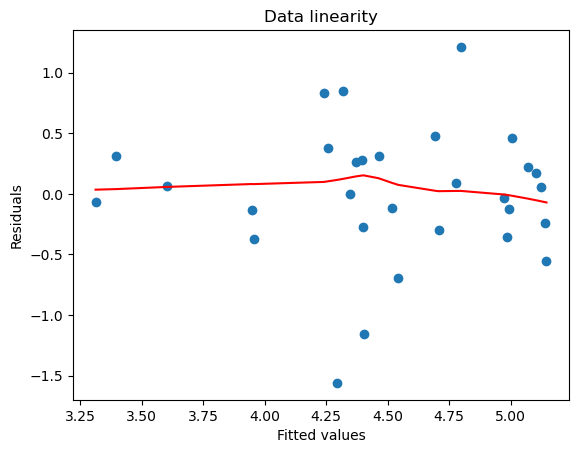

In [10]:
def check_assumptions(lin_reg, X):
    p_val = 0.05

    # Heteroscedasticidad
    if smd.het_breuschpagan(lin_reg.resid, lin_reg.model.exog)[1] < p_val:
        print('Relationship is not homoscedastic')
    else:
        print('Relationship is homoscedastic')

    # Autocorrelación
    if (durbin_watson(lin_reg.resid) < 2.5) & (durbin_watson(lin_reg.resid) > (1.5)):
        print('No autocorrelation problem')
    else:
        print('There maybe autocorrelation problems')

    # Linearidad
    plt.scatter(lin_reg.predict(X), lin_reg.resid)
    plt.ylabel('Residuals')
    plt.xlabel('Fitted values')
    plt.plot(lowess(lin_reg.resid, lin_reg.predict(X))[:,0], lowess(lin_reg.resid, lin_reg.predict(X))[:,1], c='r') 
    plt.title('Data linearity')
    
check_assumptions(lin_reg, X)

### Feature selection
After seeing the results of the first log-linear regression it can be seen that our regression could be performed better if we remove some features that are not being relevant in the model.

Two approaches were done for the feature selection:
1. The Variance Infllation Factor (VIF) was calculated to evaluate colinearity between features. 
    - Using VIF, `Vertical Velocity, Fault Proximity, Urban dummy and Temperature` were removed. The latter taking into account that temperature has less variation in Bogota than Precipitation, and these two were correlated.
2. Regularization was performed using Lasso regression to evaluate the possibilit of removng more features
    - To evaluate if more features should be removed the lambda parameter of Lasso was tuned using he Leave One Out Cross-Validation Score.

#### Variance Inflation Factor

In [11]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i+1) for i in range(X.shape[1]-1)]
vif["features"] = X.columns[1:]
vif

,VIF Factor,features
0,1.394916,Basement_dummy
1,1.516458,Age_1980
2,1.487399,Lito_Fans
3,2.554024,Lito_Shales
4,4.097101,Precipitation
5,3.938614,Temperature
6,4.996919,Urban_dummy
7,4.307979,Fault_proximity
8,5.995801,Vertical_velocity


In [12]:
X = X.drop(['Temperature', 'Fault_proximity','Vertical_velocity','Urban_dummy'], axis = 1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i+1) for i in range(X.shape[1]-1)]
vif["features"] = X.columns[1:]

Variables = list(vif['features'])

vif

,VIF Factor,features
0,1.120172,Basement_dummy
1,1.080660,Age_1980
2,1.252829,Lito_Fans
3,1.067207,Lito_Shales
4,1.230237,Precipitation


#### Lasso regression

In [13]:
X_scaled = X.iloc[:,1:].apply(lambda df :(df-np.mean(df))/np.std(df))

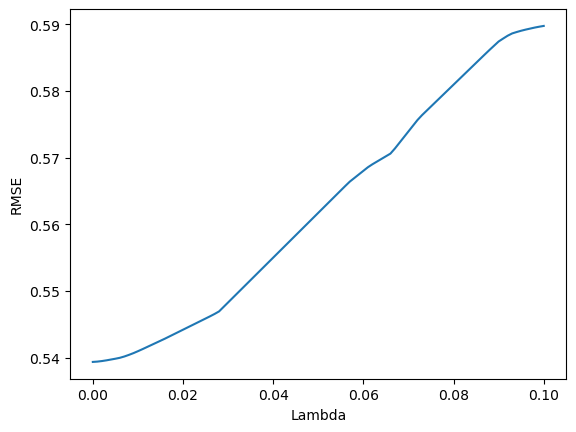

In [14]:
from sklearn.model_selection import cross_val_score

lin_reg = Lasso(alpha = 0.1)

neg_errors = []

lambdas = np.linspace(0.000000001,0.1,100+1)

for i in lambdas:
    lass_Rn = Lasso(alpha = i, fit_intercept=True)
    scores = cross_val_score(lass_Rn, X_scaled, np.log(y), cv=30, scoring = 'neg_root_mean_squared_error')
    neg_errors.append(scores.mean())
    
plt.plot(lambdas,-1*np.array(neg_errors))
plt.ylabel('RMSE')
plt.xlabel('Lambda')
plt.show()

In [15]:
opt_lambda = lambdas[np.argmax(np.array(neg_errors))]
if opt_lambda == 0.000000001:
    print('No further feature selection is suggested by Lasso regression')
else:
    lass_Rn = Lasso(alpha = opt_lambda, fit_intercept=True).fit(X_scaled, np.log(y))
    plt.stem(X_scaled.columns, lass_Rn.coef_)
    plt.xticks(rotation = 90)

No further feature selection is suggested by Lasso regression


### New Log-linear regression

In [16]:
y = DF_RC.iloc[:,0]

X = sm.add_constant(X)

In [17]:
lin_reg = sm.OLS(np.log(y), X).fit(maxiter=1000000)

RMSE = np.sqrt(np.sum((lin_reg.predict(X)-np.log(y))**2)/30)

print('RMSE:', RMSE)

lin_reg.summary()

RMSE: 0.5957690178589781


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RC   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     2.589
Date:                Mon, 27 Mar 2023   Prob (F-statistic):             0.0521
Time:                        20:57:23   Log-Likelihood:                -27.031
No. Observations:                  30   AIC:                             66.06
Df Residuals:                      24   BIC:                             74.47
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3109      1.065      4.986      0.000       3.113       7.509
Basement_dummy     0.3436      0.304      1.129      0.270      -0.284       0.972
Age_1980           0.5449      0.258      2.112      0.045       0.012       1.078
Lito_Fans         -0.9890      0.546     -1.812      0.082      -2.115       0.137
Lito_Shales        0.0004      0.700      0.001      1.000      -1.444       1.445
Precipitation     -0.0099      0.010     -1.020      0.318      -0.030       0.010
==============================================================================
Omnibus:                        7.010   Durbin-Watson:                   2.292
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                5.291
Skew:                          -0.944   Prob(JB):                       0.0710
Kurtosis:                       3.816   Cond. No.                         969.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

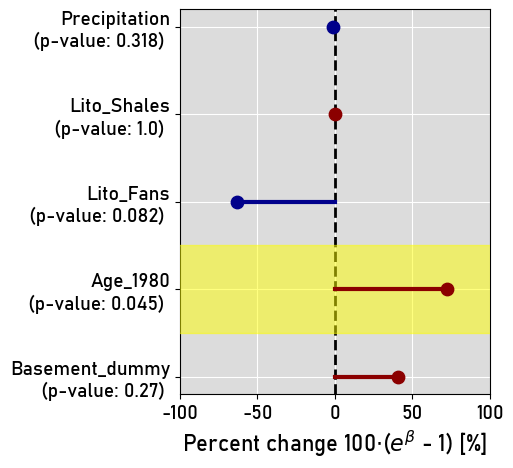

In [18]:
coef_vis(lin_reg, Variables, 'Figures/Regresión_LogLineal_withFeatureSel.png')

Relationship is homoscedastic
No autocorrelation problem


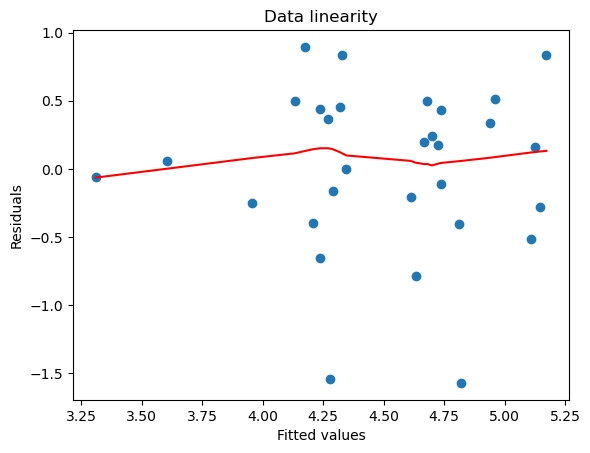

In [19]:
check_assumptions(lin_reg, X)

### Model evaluation with Leave One Out Cross Validation

In [20]:
df = pd.concat([X, np.log(y)], axis = 1)

In [21]:
errors = []
# LOOCV
for i in range(len(df)):
    
    # splitting our dataset into train and test datasets.
    train = pd.concat([df.iloc[:i], df.iloc[(i+1):]])
    test = pd.DataFrame(df.iloc[i]).T
    lin_reg = sm.OLS(train.RC, train.iloc[:,:-1]).fit(maxiter=1000000)
    
    RMSE = np.sqrt(np.sum((np.exp(lin_reg.predict(test.iloc[:,:-1])) - np.exp(test.RC))**2)/1)
    errors.append(RMSE)
    
print(np.mean(errors))

56.51742327434803


## Apply models to Household data
With the code below the log-linear regression fitted is apply to the dataset from Bogota's Cadaster. The code receives a zipped txt file and returns a csv, a geojson and a raster of the resulting estimations.

In [22]:
# Unzip IndVarModel file
with zipfile.ZipFile("Dataset for regression/Houses_for_Rn_estimation_Cataster.zip", 'r') as zip_ref:
    zip_ref.extractall("Dataset for regression")

Data is clustered spatially to minimize computation

In [23]:
df_RnModel = pd.read_table("Dataset for regression/Houses_for_Rn_estimation_Cataster.txt", delimiter = '\t')

#pre-Processing for model implementation
df_RnModel = df_RnModel.dropna()
df_RnModel['const'] = np.ones(len(df_RnModel))

x_range = df_RnModel['X'].max() - df_RnModel['X'].min()
y_range = df_RnModel['Y'].max() - df_RnModel['Y'].min()

width = 200
height = int(width * (y_range/x_range))

x_iter = np.linspace(df_RnModel['X'].min(), df_RnModel['X'].max() + x_range/width, width)
y_iter = np.linspace(df_RnModel['Y'].min(), df_RnModel['Y'].max() + y_range/height, height)

df_RnModel['Cluster'] = np.zeros(len(df_RnModel))

k = 0
for i in range(len(x_iter)-1):
    for j in range(len(y_iter)-1):
        k += 1
        df_RnModel.loc[(df_RnModel.X >= x_iter[i])&(df_RnModel.X < x_iter[i+1])&(df_RnModel['Y'] >= y_iter[j])&(df_RnModel['Y'] < y_iter[j+1]), 'Cluster'] = k
              
df_RnModel = df_RnModel.groupby('Cluster').mean()

### Log-Linear regression
Take the clusterized tabular data with independent variables, predict the Radon concentrations and export a csv with the results

In [24]:
df_RnModel_reg = df_RnModel[list(X.columns)]

df_RnModel['LinReg'] = np.exp(lin_reg.predict(df_RnModel_reg))

In [25]:
df_RnModel[['X','Y','LinReg']].to_csv('Regression results/LinReg_model_results.csv')

In [26]:
df_RnModel.describe()

,X,Y,Fault_proximity,Basement_dummy,Lito_Fans,Lito_Shales,Precipitation,Temperature,Urban_dummy,Vertical_velocity,Age_1980,const,LinReg
count,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.000000,14335.0,14335.000000
mean,-74.105089,4.646885,8328.109755,0.011058,0.228253,0.073265,105.109380,14.469053,0.906898,2.437027,0.565448,1.0,84.977695
std,0.044944,0.073454,2970.494614,0.072271,0.417124,0.259770,17.789156,0.300140,0.288816,0.528797,0.384369,0.0,32.813537
min,-74.215555,4.435725,12.291032,0.000000,0.000000,0.000000,60.317732,13.400901,0.000000,1.393433,0.000000,1.0,21.620487
25%,-74.135562,4.601546,6177.865564,0.000000,0.000000,0.000000,93.207054,14.307791,1.000000,2.078694,0.154701,1.0,58.795166
50%,-74.104593,4.643539,8188.211625,0.000000,0.000000,0.000000,103.879396,14.439993,1.000000,2.237558,0.666667,1.0,84.858722
75%,-74.072363,4.701648,10355.572546,0.000000,0.000000,0.000000,112.861134,14.656436,1.000000,2.782628,0.945946,1.0,110.290612
max,-74.001702,4.830332,15580.354272,1.000000,1.000000,1.000000,185.944550,15.725818,1.000000,4.619085,1.000000,1.0,208.820432


### Rasterize the results
1. Create geodataframe with XY coorinates of clusters and export to geojson
2. Rasterize geojson

In [27]:
gdf = gpd.GeoDataFrame(df_RnModel['LinReg'], geometry=gpd.points_from_xy(df_RnModel.X, df_RnModel.Y))
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('EPSG:3116')
gdf = gdf.set_crs('EPSG:3116')
gdf.to_file('Regression results/Rn_estimations.geojson', driver="GeoJSON") 

In [28]:
ds_points = ogr.Open('Regression results/Rn_estimations.geojson')

In [29]:
ds_points
lyr = ds_points.GetLayer() 

In [30]:
driver = gdal.GetDriverByName('GTiff')

spatref = osr.SpatialReference()
spatref.ImportFromEPSG(3116)
wkt = spatref.ExportToWkt()

outfn = 'Regression results/LogLinear_estimations.tif'
nbands = 1
nodata = 0
xres = 250
yres = -250

xmin = gdf.geometry.x.min()
xmax = gdf.geometry.x.max() 
ymin = gdf.geometry.y.min()
ymax = gdf.geometry.y.max()
dtype = gdal.GDT_Float64

xsize = abs(int((xmax - xmin) / xres))
ysize = abs(int((ymax - ymin) / yres))

ds = driver.Create(outfn, xsize, ysize, nbands, dtype)
ds.SetProjection(wkt)
ds.SetGeoTransform([xmin, xres, 0, ymax, 0, yres])
ds.GetRasterBand(1).Fill(0)
ds.FlushCache()

gdal.RasterizeLayer(ds, [1], lyr, options=['ATTRIBUTE=LinReg', 'ALL_TOUCHED=TRUE'])
ds.GetRasterBand(1).SetNoDataValue(nodata) 
ds = None

## Assessment of RC estimations

In [31]:
Geo_mean = np.exp(np.mean(np.log(df_RnModel.LinReg)))

In [32]:
print(Geo_mean)

77.61618371525857


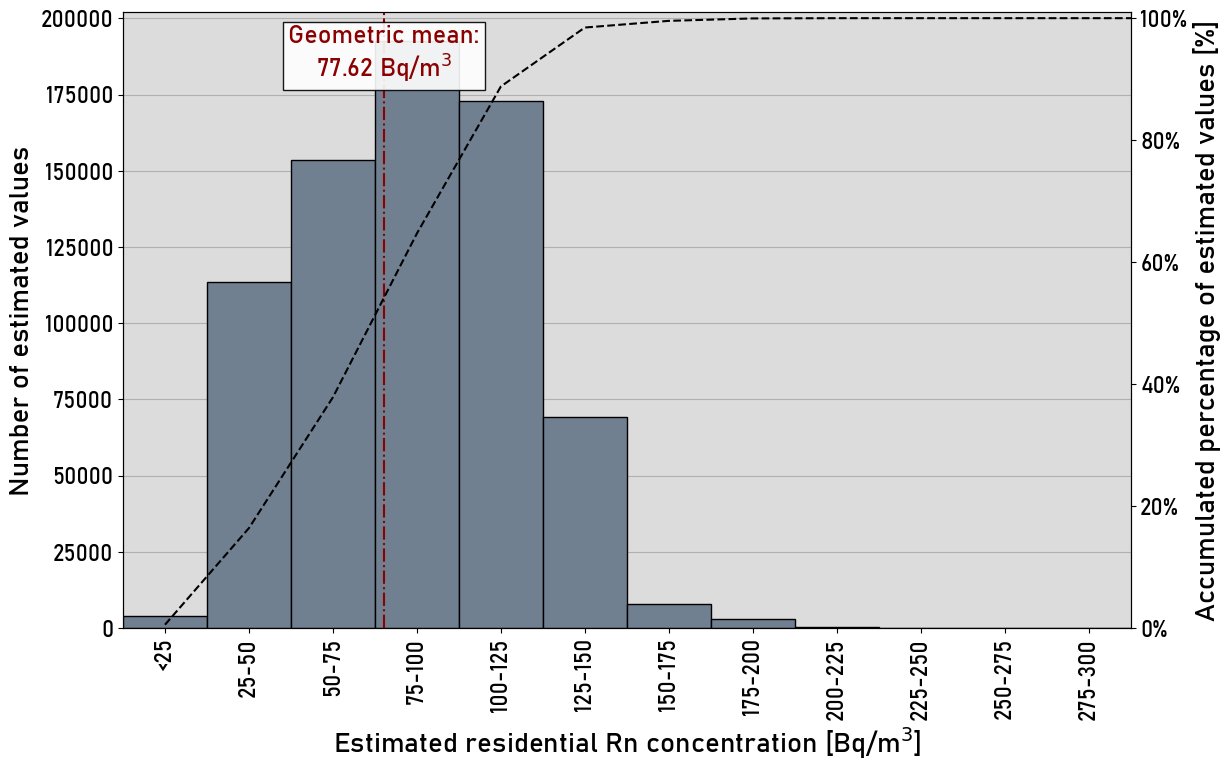

In [37]:
# create figure
fig = plt.figure(figsize = (13,8))

# send grid to back
plt.grid(axis='y', zorder = -1)

# Compute histogram
h = plt.hist(df_RnModel.LinReg, bins = np.arange(0,450,25), 
             edgecolor = 'k', color = 'slategray', zorder = 4)

# compute median calculation
median = df_RnModel.LinReg.median()

# Edit axis
ax = plt.gca()
ax.set_facecolor('gainsboro')

# Edit figure
plt.ylabel('Number of estimated values',fontdict = font, fontsize = 20)
plt.xlabel('Estimated residential Rn concentration [Bq/m$^3$]',fontdict = font, fontsize = 20)
plt.xticks(np.arange(12.5,420,25))
ax.set_xticklabels(['<25','25-50','50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225','225-250','250-275',
                    '275-300','300-325','325-350','350-375','375-400','400-425'], fontdict = font, fontsize = 14, rotation = 90)
ax.set_yticklabels(np.arange(0,220000,25000), fontdict = font, fontsize = 16)
plt.xlim((0,300))


#Create second yaxis
ax2 = ax.twinx() 
ax2.set_ylim((0,1.01))

# Plot accumulated prcentage of measurements.
plt.plot(np.arange(12.5,420,25),np.cumsum(h[0])/len(df_RnModel), zorder=5, c = 'k', ls ='--')
ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)
ax2.set_ylabel('Accumulated percentage of estimated values [%]', fontdict = font, fontsize = 20)

# Plot Geometric mean value
ax2.axvline(Geo_mean, c = 'darkred',ls='-.')
ax2.text(Geo_mean, 0.94,'Geometric mean:\n'+str(round(Geo_mean,2))+' Bq/m$^3$', va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9), family = font['family'], fontsize = 18, color = 'darkred')


# Save figure histogram
fig.savefig('Figures/Estimated_Rn_Histogram.png', dpi = 150)